### Generalized additive model with backfitting

API : Based on the API for Scikit proposed by Alexandre Gramfort.

Fit a model : $ Y = f_1(X_1) + \cdots + f_p(X_p) + noise $

It gives an 'intelligible model', meaning that we can visualize in a 2-D plot the individual contribution of each features to the model.

$ \underline{References :} $

Backfitting and GAM presented in this paper : $ \textit{ Hastie, T. J. & Tibshirani, R. J. (1990). "Generalized Additive Models". Monographs on Statistics and Applied Probability 43.} $

Benchmarks using GAMs (with different smoothers for the shape functions) are given in this paper : $ \textit{ Yin Lou, Rich Caruana & Johannes Gehrke : "Intelligible Models for Classification and Regression".} $

$ \textbf{Warning : }$The code uses scikit learn 0.18

In [30]:
%matplotlib inline

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sklearn.metrics as met
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.linear_model import RidgeCV
import scipy.optimize as op
from hyperopt import fmin as hyperopt_fmin
from hyperopt.pyll.stochastic import sample
from hyperopt import tpe, hp, STATUS_OK, space_eval
from sklearn.model_selection import train_test_split

def sorted_plot(X, Y, ls='-', c='blue', label=''):
    """
    sort the data according to X's axis to have nice plot of the shape functions
    :return 0
    """
    graphics = np.empty(shape = (X.shape[0], 2))
    graphics[:X.shape[0], 0] = X.reshape((X.shape[0],))  # sorting the data for the plot Y_pred vs X1
    graphics.sort(axis=0)
    graphics[:X.shape[0], 1] = Y.reshape((X.shape[0],))[X.reshape((X.shape[0],)).argsort(axis=0)]

    plt.plot(graphics[:, 0], graphics[:, 1], linestyle=ls, color=c, label=label)

    return 0


# The class 

In [67]:

class GeneralizedAdditiveRegressor(object):
    """Fit Generalized Additive Model with symmetric backfitting (we actualize the residuals once per batch)
    This way, the order of the features doesn't matter.
    
    Parameters
    ---------
    
    smoothers : list of estimators fo the shape funtions. It could be any estimator with fit() and predict() functions implemented.
        Note that the length of this list (the number of estimators) has to be equal to the number of features ( one function per feature).
        If you want the same smoothers for all the shape functions, you can pass only the estimator (not in a list !) and it will create a         list of cloned estimator of length (n_features) before the fit. 
    
    max_iter : the number of iteration to run in the backfitting algorithm. (default is 10)
    
    ridge_alpha : the regularization coefficient for ridge regression upon the shape functions in the backfitting 
    (in order to rescale them)
    
    Attributes
    ----------
    
    smoothers_ : list of the fitted smoothers (the shape functions)
    
    ridge : ridge regressor used after each batch in the backfitting to rescale the shape functions
        Its parameter alphas is given by the user (ridge_alphas)
    
    """
    
    
    def __init__(self, smoothers, max_iter=10, ridge_alphas=10.):
        self.smoothers = smoothers
        self.max_iter = max_iter
        self.ridge_alphas = ridge_alphas
        
    def fit(self, X, y):
        """Fit the shape function of each features with the backfitting algorithm.
        Please note that the shape functions are centered (not reduced).
        
        Parameters
        ----------
        X : array-like, shape=(n_samples, n_features)
            The input samples. 
            
        Returns
        -------
        self : object
            The Generalized Additive Model with the fitted shape functions
        """
        
        n_samples, n_features = X.shape
        
        if not isinstance(self.smoothers, list):
            self.smoothers_ = [clone(self.smoothers) for i in range(n_features) ]
            self.ridge = RidgeCV(alphas = [self.ridge_alphas]*len(self.smoothers_), fit_intercept=False)
        else:
            self.smoothers_ = [clone(self.smoothers[j]) for j in range(n_features) ]
            self.ridge = RidgeCV(alphas = [self.ridge_alphas]*len(self.smoothers_), fit_intercept=False)
            
        self.y_mean_ = np.mean(y)
        self.rmse_ = [] # array to stock the train error over the iteration
        y -= y.mean()
        temp = np.zeros(shape=(n_samples, n_features)) # array to stock the shape function for re-use in the next iteration
        shape_functions = np.zeros(shape=(n_samples, n_features))
        for i in range(self.max_iter):
            for j in range(n_features):
                # select all the columns except the j-th one
                idx = list(set(np.arange(0, n_features, 1)) - set([j])) 
                
                #Compute the residuals of the previous iteration          
                residuals = y.reshape((n_samples,1)) - temp[:, idx].sum(axis=1, keepdims=True).reshape((n_samples, 1)) 
                residuals -=residuals.mean()
                residuals = residuals
                #print(np.amin(residuals), np.amax(residuals), 'iteration number %s'%(i+1))
               
                self.smoothers_[j].fit(X[:, j:j+1], residuals.reshape((n_samples,))) #reshape cause deprecation warning
                shape_functions[:, j]= self.smoothers_[j].predict(X[:, j:j+1])
                shape_functions[:, j] -= shape_functions[:, j].mean()
            
            # RidgeRegression on top of the shape function in order to 're-scale' each shape functions
            self.ridge.fit(shape_functions, y)
            coef = self.ridge.coef_
            shape_functions *= coef
            
            y_pred = shape_functions.sum(axis=1)
            y_pred -= y_pred.mean()
            self.rmse_.append(met.mean_squared_error(y_pred, y))
            
            temp=shape_functions.copy()
            #plt.scatter(1, np.abs(residuals.min()), c='g', label='iteration = %s'%i)
            #plt.scatter(2, np.abs(residuals.max()), c='r')
            #plt.legend()
            #plt.show()
        return self

    
    def tranform(self, X):
        """ Transform function, return the prediction of the shape functions in each dimensions. 
        For pipeline use.
        
        Parameters
        ----------
        
        X : array like of shape (n_samples, n_features).
            data to be transformed
        
        Returns
        -------
        
        shape_functions : np.array of shape(n_ sampes, n_features).
            Prediction of each shape function for each feature.
        """
        
        n_samples, n_features = X.shape
        shape_functions = np.empty_like(X)
        for j in range(n_features):
            shape_functions[:, j] = self.smoothers_[j].predict(X[:, j])
        
        return shape_functions
        
        
    def predict(self, X):
        """ Predict regression target for X.
        
        The prediction is made using the GAM model (sum of the shape functions)
        """
        
        n_samples, n_features = X.shape
        y = np.ones(n_samples) * self.y_mean_
        for j in range(n_features):
            y += self.smoothers_[j].predict(X[:, j:j+1])
    
        return y
    


## Toy example 

Simule a 3-featured GaM and learn the shape functions.

The GaM class offers the choice of the smoothers, we will work with gaussian process.

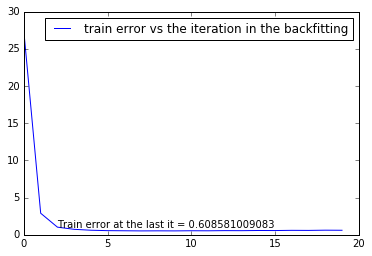

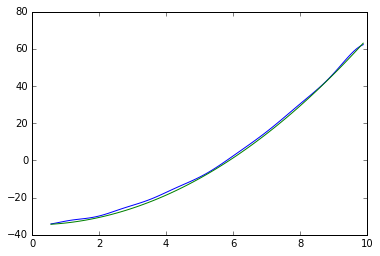

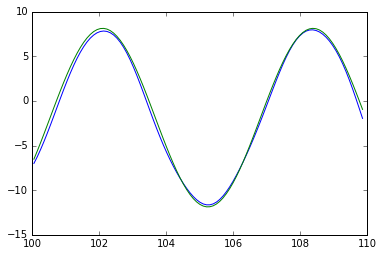

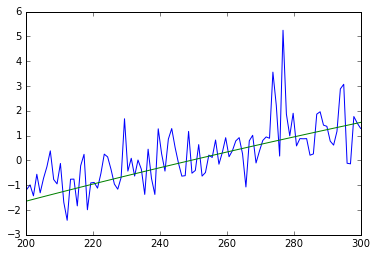

RMSE on test = 1.0286931657


In [68]:
def f1(x):
    return x ** 2

def f2(x):
    return 10 * np.sin(x)

def f3(x):
    return np.sqrt(x)

def f(X):
    return f1(X[:, 0]) + f2(X[:, 1])  + f3(X[:, 2])

nugget = 1e-2
kernel = C(1.) * RBF(1.)
n = 200 # number of points
p = 3 #number of features

np.random.seed(76)
X1 = np.random.uniform(0.5, 10., n)[:, np.newaxis]
X2 = np.random.uniform(100, 110, n)[:, np.newaxis]
X3 = np.random.uniform(200, 300, n)[: , np.newaxis]

X = np.concatenate((X1, X2, X3), axis=1)
Y = f(X) + np.random.normal(loc=0, scale=1e-2, size=(n,))


idx_train, idx_test = train_test_split(np.arange(0, n, 1),  train_size=0.7, random_state=0)

n_train = len(idx_train)
n_test = len(idx_test)
X_train = X[idx_train]
X_test = X[idx_test]
Y_train = Y[idx_train]
Y_test = Y[idx_test]
gam = GeneralizedAdditiveRegressor(smoothers = GaussianProcessRegressor(alpha = nugget, optimizer=None), max_iter=20)
gam.fit(X_train, Y_train)
gam.fit(X_train, Y_train)

plt.plot(range(len(gam.rmse_)), gam.rmse_, label='train error vs the iteration in the backfitting')
plt.legend(loc='best')
plt.annotate('Train error at the last it = %s'%gam.rmse_[-1], xy=(2,1))
plt.show()
for j, f in enumerate([f1, f2, f3]) :
    xx = np.linspace(np.amin(X[idx_train, j]), np.amax(X[idx_train, j]), 100).reshape(100,1)
    f_hat = gam.smoothers_[j].predict(xx)
    plt.plot(xx, f_hat)
    plt.plot(xx, f(xx) - f(xx).mean(), c='g')
    plt.show()    

y_pred = gam.predict(X[idx_test])
rmse = np.sqrt(met.mean_squared_error(y_pred - y_pred.mean(), Y_test - Y_test.mean()))
print('RMSE on test = %s'%rmse)
    


As we can see, the two first shape functions are well recovered by the model, but not the third one.
This is a problem of hyper-parameters in the GaussianProcessRegressor used, the length scale is too small leading to an erratic fit. 

We should remediate this problem by writting an hyper-opt objective function (using test MSE as a loss to minimize).
We propose such a function only in the case of GPs using the hyperopt_fmin algo. Since the user has the choice of any scikit regressor, he/she is free to write a similar function for different smoothers (RandomForest or SVM for example).

## Hyperopt

In [69]:
def obj_function(param):
    """obj_func for hyperopt on a GAM with 0.18 GP as smoothers
    return : global mse on the test set.
    """
    
    n_features = (len(param) - 2)//2 
    
    #print('param={0}'.format(param))
    shape_parameters = [0]*(2*n_features) #a list of dict to contain the parameters of each GP
    c=0
    i=0
    while i <= 2* n_features - 1 :
        #print('iteration nb : %s'%obj_function.nb_iter)
        shape_parameters[c] = {}
        shape_parameters[c]['constant_value'] = param[i]
        shape_parameters[c]['length_scale'] = param[i+1]
        i=i+2
        c+=1
    alpha_ = param[-2]  # all the GPs share the same nugget (noise variance estimation)
    ridge_alphas = param[-1]
    
    smoothers=[]
    for i in range(n_features):      
        constant_value = shape_parameters[i]['constant_value']
        length_scale = shape_parameters[i]['length_scale']
        
        smoothers.append(GaussianProcessRegressor(kernel=C(constant_value)*RBF(length_scale), alpha=alpha_, optimizer=None))
    
    gam = GeneralizedAdditiveRegressor(smoothers, max_iter=15, ridge_alphas=ridge_alphas)
    gam.fit(X_train, Y_train)
    y_pred = gam.predict(X_test)
    score =  met.mean_squared_error(Y_test - Y_test.mean(), y_pred - y_pred.mean())
    #print('score=%s \n'%score)
    return score


def create_space(n_feature):
    """ Function to create a search space for the hypers of the a sklearn 0.18 GP kernel.
    The order of the hypers is designed to work with  obj_function().
    
    Return a search space for hyperopt_fmin()"""
    
    n_sample = X_train.shape[0]
    size = [ X[:, i].max() - X[:, i].min() for i in range(n_feature)]
    
    constant_space = [hp.loguniform('constant_value%s'%i, np.log(10)*-2, np.log(10)*2) for i in range(n_feature)]
    l_scale_space = [hp.uniform('length_scale%s'%i, (size[i]/n_sample), size[i]) for i in range(n_feature)]
    space =[]
    #create an alternate search space for hyper-opt
    for j in range(n_feature):
        space.append(constant_space[j])
        space.append(l_scale_space[j])
    
    space.append(hp.loguniform('alpha', -11, 2))
    space.append(hp.loguniform('ridge', -2, 2))
    
    return space

  



We can now run the hyperopt, please note that the number of trials (max_evals) really depends of your data, since the backfitting method can already take a lot of computation time. Hence, we recommand a small value for a first trial.

In [70]:
space = create_space(p)
best = hyperopt_fmin(obj_function,
                     space = space,
                     algo=tpe.suggest,
                     max_evals=30
                    )

length=[]; constant=[];
for key in sorted(best.keys()):
    if 'alpha' in key:
        alpha_=best[key]
    if 'length' in key:
        length.append(best[key])
    if 'constant' in key:
        constant.append(best[key])
    if 'ridge' in key:
        ridge_alphas = best[key]

Now we can fit the GAM with optimized smoothers for each features.

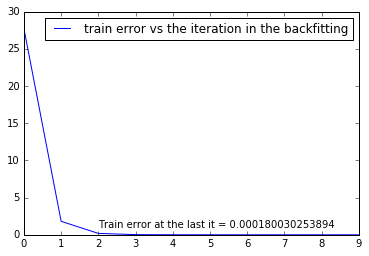

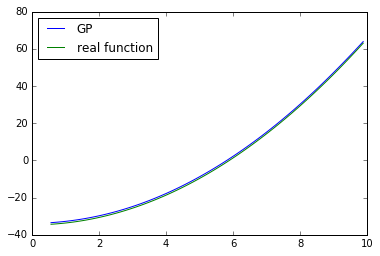

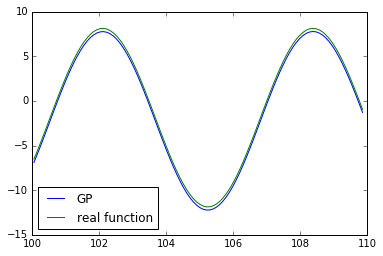

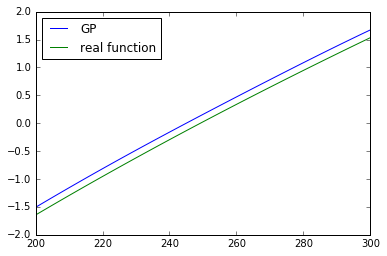

RMSE on test = 0.0156436669556
optimal ridge regularization coefficient = 0.141909554496
lengths_scale of the GPs = [5.8314209057971196, 1.8024277465056442, 91.244871304902503]
nugget estimated (alpha) = 0.000239036908663


In [71]:
smoothers=[]

for i in range(p):
    smoothers.append(GaussianProcessRegressor(kernel=C(constant[i])*RBF(length[i]), alpha=alpha_, optimizer=None))
    
gam_optimized = GeneralizedAdditiveRegressor(smoothers, max_iter=10, ridge_alphas=ridge_alphas)
gam_optimized.fit(X_train, Y_train)

plt.plot(range(len(gam_optimized.rmse_)), gam_optimized.rmse_, label='train error vs the iteration in the backfitting')
plt.legend(loc='best')
plt.annotate('Train error at the last it = %s'%gam_optimized.rmse_[-1], xy=(2,1))
plt.show()

for j, f in enumerate([f1, f2, f3]) :
    xx = np.linspace(np.amin(X[idx_train, j]), np.amax(X[idx_train, j]), 100).reshape(100,1)
    f_hat = gam_optimized.smoothers_[j].predict(xx)
    plt.plot(xx, f_hat, label='GP')
    plt.plot(xx, f(xx) - f(xx).mean(), c='g', label='real function')
    plt.legend(loc='best')
    plt.show()   

y_pred = gam_optimized.predict(X[idx_test])
rmse = np.sqrt(met.mean_squared_error(y_pred - y_pred.mean(), Y_test - Y_test.mean()))
print('RMSE on test = %s'%rmse)
res = y_pred - y_pred.mean()- Y_test - y_pred.mean()
print('optimal ridge regularization coefficient = %s'%ridge_alphas)
print('lengths_scale of the GPs = %s'%length)
print('nugget estimated (alpha) = %s'%alpha_)

The result is much better both in term of global RMSE (which is the only concrete value we  can use to judge when we have real data), and in term of the allure of the shape functions.

# Introducing correlation

A model : $Y = f1(X_1) + f2(X_2) + g(X_1, X_2) + noise$

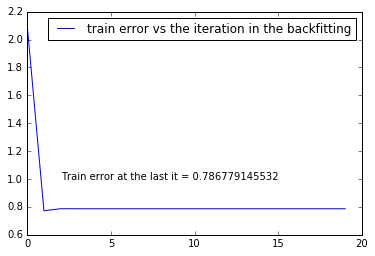

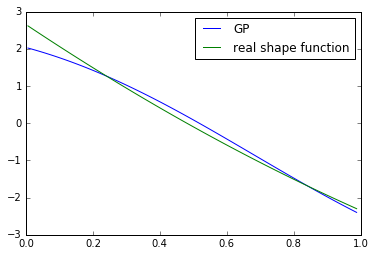

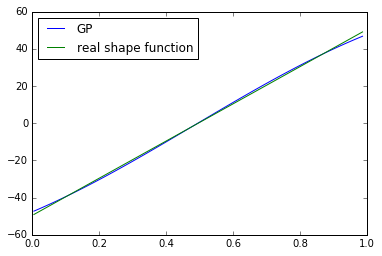

RMSE on test = 0.628018761592


In [72]:
""" Test correlation """
def f1(x):
    return (x - 3) ** 2

def f2(x):
    return 100 * x

def f3(x, y):
    return np.sin(x*y*np.pi)

def f(X):
    return f1(X[:, 0]) + f2(X[:, 1])  + f3(X[:, 0], X[:, 1])


n = 200 # number of points
M = 15
p = 2 #number of features

np.random.seed(76)
X1 = np.random.uniform(0, 1, n)[:, np.newaxis]
X2 = np.random.uniform(0, 1, n)[:, np.newaxis]

X = np.concatenate((X1, X2), axis=1)
Y = f(X) + np.random.normal(loc=0, scale=1e-2, size=(n,))

idx_train, idx_test = train_test_split(np.arange(0, n, 1),  train_size=0.7, random_state=0)
n_train = len(idx_train)
n_test = len(idx_test)
X_train = X[idx_train]
X_test = X[idx_test]
Y_train = Y[idx_train]
Y_test = Y[idx_test]
smoothers = []
kernel = C(1.) * RBF(1.)
nugget=10e-2

for j in np.arange(0, p, 1):
    smoothers.append(GaussianProcessRegressor(alpha=nugget, kernel=clone(kernel), optimizer=None))
    
    
gam = GeneralizedAdditiveRegressor(smoothers, max_iter=20, ridge_alphas=100)
gam.fit(X_train, Y_train)

plt.plot(range(len(gam.rmse_)), gam.rmse_, label='train error vs the iteration in the backfitting')
plt.legend(loc='best')
plt.annotate('Train error at the last it = %s'%gam.rmse_[-1], xy=(2,1))
plt.show()
for j, f in enumerate([f1, f2]) :
    xx = np.linspace(np.amin(X[idx_train, j]), np.amax(X[idx_train, j]), 100).reshape(100,1)
    f_hat = gam.smoothers_[j].predict(xx)
    plt.plot(xx, f_hat - f_hat.mean(), label='GP')
    plt.plot(xx, f(xx) - f(xx).mean(), c='g', label='real shape function')
    plt.legend(loc='best')
    plt.show()    
    

y_pred = gam.predict(X_test)
y_pred -= y_pred.mean()

rmse = met.mean_squared_error(y_pred, Y_test - Y_test.mean())
print('RMSE on test = %s'%rmse)


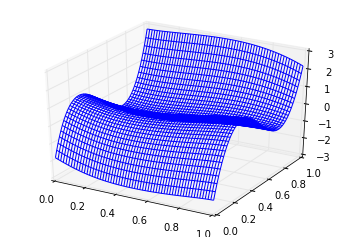

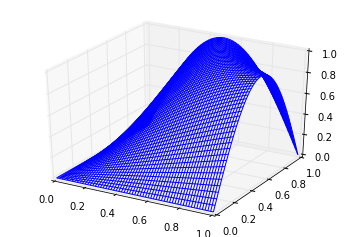

In [73]:
y_pred = gam.predict(X_train)
res = Y_train - y_pred
res -= res.mean()


corel_estimator = GaussianProcessRegressor(kernel = RBF([1,1]), optimizer=None)
res = Y_train - y_pred
res -= res.mean()
corel_estimator.fit(X_train, res)

axe1, axe2 = np.meshgrid(np.linspace(0, 1, n_test), np.linspace(0, 1, n_test))
axe1_fit = np.ndarray.flatten(axe1).reshape((n_test**2,1))
axe2_fit = np.ndarray.flatten(axe2).reshape((n_test**2,1))
grid = np.concatenate((axe1_fit, axe2_fit), axis=1)
y_pred_test = corel_estimator.predict(grid)
y_pred_test = y_pred_test.reshape((n_test, n_test))

fig = plt.figure()
ax = fig.gca(projection = '3d')
wiref = ax.plot_wireframe(axe1, axe2, y_pred_test)
plt.show()

#The true function
fig2 = plt.figure()
ax2 = fig2.gca(projection = '3d')
wiref2 = ax2.plot_wireframe(axe1, axe2, f3(grid[:,0], grid[:, 1]).reshape((n_test, n_test)))
plt.show()




Not really good at picking up correlation... Still got to work on this